In [ ]:
import os
import cv2
import numpy as np
import mediapipe as mp

mp_holistic = mp.solutions.holistic  # MediaPipe holistic model
mp_drawing = mp.solutions.drawing_utils

# Function to extract keypoints
def extract_keypoints(results):
    pose=np.array([[res.x,res.y,res.z,res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    lh=np.array([[res.x,res.y,res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh=np.array([[res.x,res.y,res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    #face=np.array([[res.x,res.y,res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    return np.concatenate([pose,lh,rh])

def mediapipe_detection(image, model):
    # so opencv reads the image in form of bgr but for detection using mediapipe we require the format to be RGB
    # so cv2.cvtcolor helps in recolouring the image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable this helps us in saving a bit of memory
    # so here image is going to be a frame from video
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    # so that opencv can produce results in bgr format
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results
mp_holistic = mp.solutions.holistic # Holistic model
# used for drawing the utilities - points and structure from the midiapipe which is its main function through .drawing_utils
mp_drawing = mp.solutions.drawing_utils # Drawing utilities
# Paths
IMAGE_PATH = "finaldataset/train"  # Folder containing class folders
SAVE_PATH = "keypoints_data"
os.makedirs(SAVE_PATH, exist_ok=True)

# Initialize holistic model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    for class_name in os.listdir(IMAGE_PATH):  # Each folder is a class
        class_path = os.path.join(IMAGE_PATH, class_name)
        if not os.path.isdir(class_path):
            continue
        
        save_class_path = os.path.join(SAVE_PATH, class_name)
        os.makedirs(save_class_path, exist_ok=True)

        for img_name in os.listdir(class_path):
            if img_name.endswith(".jpg") or img_name.endswith(".png"):
                img_path = os.path.join(class_path, img_name)
                frame = cv2.imread(img_path)
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
                    image, results = mediapipe_detection(frame, holistic)
                    keypoints = extract_keypoints(results)
    
                    # Save keypoints
                    np.save(os.path.join(save_class_path, img_name.replace(".jpg", ".npy").replace(".png", ".npy")), keypoints)

print("Keypoint extraction complete.")


In [1]:
import os
import numpy as np
from tensorflow.keras.utils import to_categorical
SAVE_PATH = "keypoints_data"
SEQUENCE_LENGTH = 1  # Define sequence length

# Get class labels
LABELS = sorted(os.listdir(SAVE_PATH))  # Class names
X, y = [], []

# Load and group frames into sequences
for class_index, class_name in enumerate(LABELS):
    class_folder = os.path.join(SAVE_PATH, class_name)
    class_files = sorted([f for f in os.listdir(class_folder) if f.endswith(".npy")])

    # Ensure we have enough frames
    for i in range(0, len(class_files) - SEQUENCE_LENGTH + 1, SEQUENCE_LENGTH):
        sequence = [np.load(os.path.join(class_folder, class_files[j])) for j in range(i, i + SEQUENCE_LENGTH)]
        X.append(sequence)
        y.append(class_index)

# Convert to numpy arrays
X = np.array(X)
y = to_categorical(y, num_classes=len(LABELS))

# Print shapes
print("X shape:", X.shape)  # Expected: (num_samples, 30, feature_dim)
print("y shape:", y.shape)  # Expected: (num_samples, num_classes)


X shape: (58, 1, 258)
y shape: (58, 7)


In [26]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_test.shape

(12, 1, 258)

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
# adding the logs folder
log_dir = os.path.join('Logs')
# tensorboard is a part of tensorflow monitoring the model training using a web app
# will help to track the accuracy during the training
tb_callback = TensorBoard(log_dir=log_dir)

In [33]:

model = Sequential()

model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(1,258)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
# return seq as false cuz next is dense layer so not required
model.add(LSTM(64, return_sequences=False, activation='relu'))
# adding 64 units for dense layer
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
# actions is having three values so the actions.shape of [0] is also 3 in shape 
# using softmax so that the values are confined in 0 to 1 the value will sum up and provide 1
model.add(Dense(7, activation='softmax'))
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                       │ (None, 1, 64)               │          82,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_19 (LSTM)                       │ (None, 1, 128)              │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_20 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 237,383 (927.28 KB)

 Trainable params: 237,383 (927.28 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history=model.fit(X_train, y_train, epochs=150, validation_data=(X_test, y_test), callbacks=[tb_callback])

Epoch 1/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - categorical_accuracy: 0.1431 - loss: 1.9455 - val_categorical_accuracy: 0.0833 - val_loss: 1.9460
Epoch 2/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - categorical_accuracy: 0.3528 - loss: 1.9430 - val_categorical_accuracy: 0.0833 - val_loss: 1.9460
Epoch 3/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - categorical_accuracy: 0.3320 - loss: 1.9403 - val_categorical_accuracy: 0.0833 - val_loss: 1.9462
Epoch 4/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - categorical_accuracy: 0.3216 - loss: 1.9379 - val_categorical_accuracy: 0.0833 - val_loss: 1.9463
Epoch 5/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - categorical_accuracy: 0.3320 - loss: 1.9343 - val_categorical_accuracy: 0.0833 - val_loss: 1.9464
Epoch 6/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - categorical_accuracy: 0.3111 - loss: 1.9305 - val_categorical_accuracy: 0.0833 - val_loss: 1.9468
Epoch 7/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - categorical_accuracy: 0.3320 - loss: 1.9227 

In [35]:
model.save('model.keras')

In [36]:
model.save('model.h5')

In [37]:
train_accuracy=[]
val_accuracy=[]
train_loss=[]
val_loss=[]

In [38]:
train_accuracy.extend(history.history['categorical_accuracy'])
val_accuracy.extend(history.history['val_categorical_accuracy'])
train_loss.extend(history.history['loss'])
val_loss.extend(history.history['val_loss'])

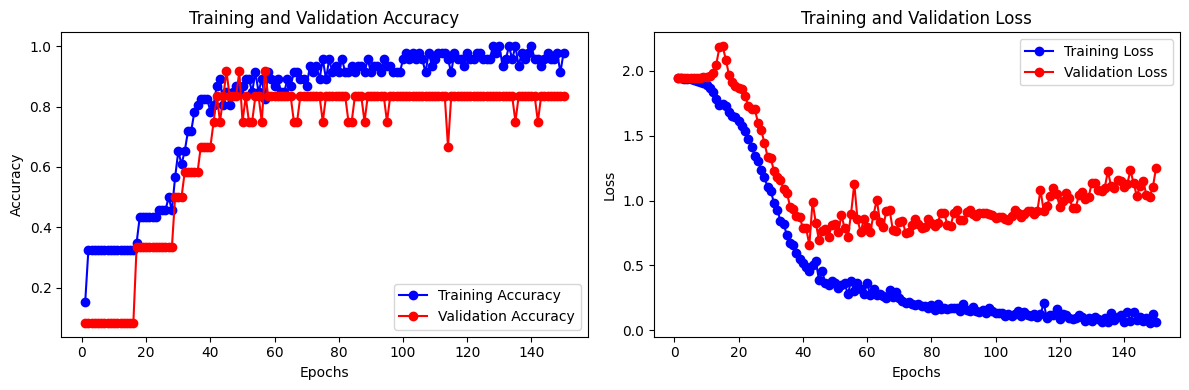

In [39]:
import matplotlib.pyplot as plt
epochs = range(1, len(train_accuracy) + 1)
# Plotting Training and Validation Accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs,train_accuracy , 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs,train_loss , 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [40]:
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_pred_max_prob = np.max(Y_pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 836ms/step


In [41]:
Y_pred_classes

array([5, 1, 0, 2, 4, 3, 5, 4, 6, 4, 1, 6], dtype=int64)

In [42]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
        

In [43]:
from sklearn.metrics import accuracy_score, precision_score, classification_report
from sklearn.metrics import confusion_matrix
import itertools
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix


In [44]:
confusion_mtx

array([[1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 2, 0, 0],
       [0, 0, 0, 0, 0, 2, 0],
       [0, 0, 0, 0, 1, 0, 2]], dtype=int64)

In [45]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Assuming Y_true and Y_pred_classes are defined
# Y_true: Actual labels
# Y_pred_classes: Predicted labels

# Compute accuracy
accuracy = accuracy_score(Y_true, Y_pred_classes)
print("Accuracy:", accuracy)

# Compute precision
precision = precision_score(Y_true, Y_pred_classes, average='weighted')
print("Precision:", precision)

# Compute recall
recall = recall_score(Y_true, Y_pred_classes, average='weighted')
print("Recall:", recall)

# Compute F1-score
f1 = f1_score(Y_true, Y_pred_classes, average='weighted')
print("F1 Score:", f1)


Accuracy: 0.8333333333333334
Precision: 0.875
Recall: 0.8333333333333334
F1 Score: 0.8388888888888889
